# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.

**Refer to the material in units 7-8 for conceptual background.**

In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
5,1350,2,R&R INT NIGHT,RONNIE,Alright. Two minutes.,FEMALE
6,1350,4,DESERTED CAR PARK EXT NIGHT,OTHER,Where you going?,MALE
7,1350,4,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"I'm gonna get help. Oh where's my phone? Oh Kevin. Kevin you smashed it, didn't ya? Kevin, Kevin, where's your phone?",FEMALE
8,1350,4,DESERTED CAR PARK EXT NIGHT,OTHER,In my right pocket.,MALE
9,1350,4,DESERTED CAR PARK EXT NIGHT,OTHER,I'm done for.,MALE


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split

if False:
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.5 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))
    
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility 

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)
print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

1394
1254 140
Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [4]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [5]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [6]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    tokens = character_text.split()   # just a simple tokenization, to be replaced
    return tokens

In [7]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [8]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [9]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [10]:
training_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 20749 stored elements in Compressed Sparse Row format>

In [11]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [12]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [13]:
val_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 3618 stored elements in Compressed Sparse Row format>

In [14]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [15]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        if not ranking.get(target):
            print("No matching target in training for", target)
            print(ranking)
            continue
            #ranking[target] = len(ranking)
            
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [16]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted([str(x) for x in list(set(df.sort_values(['doc1'])['doc1']))])
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(float(x))
        new_row.append(1.0)
        cm.append(new_row)
    final_row = [1.0,] * (len(test_labels)+2)
    cm.append(final_row)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25


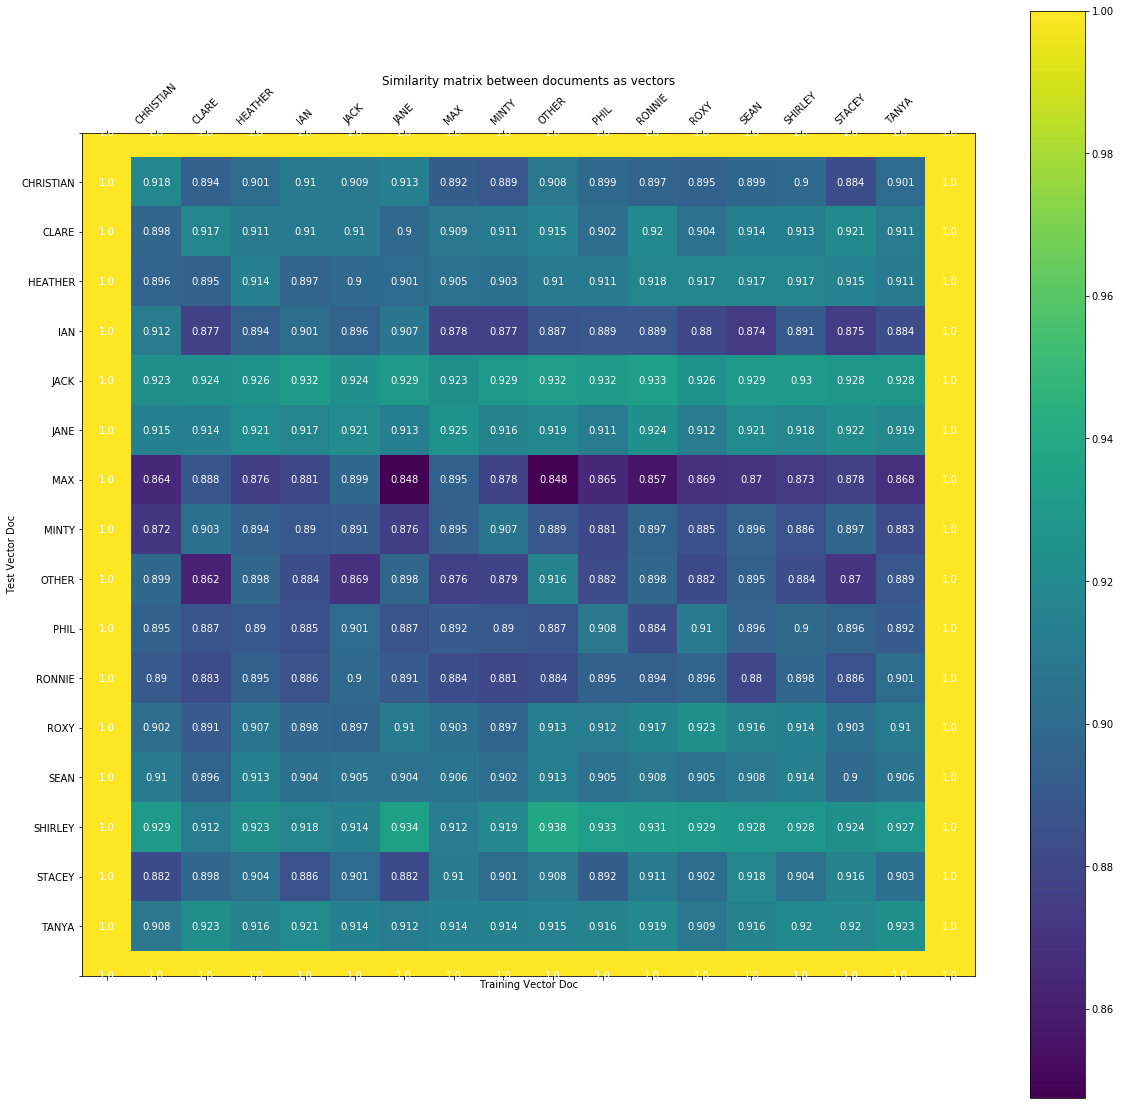

In [17]:
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [18]:
# SOLUTION Q1

# We will try a number of pre-processing techniques, then test the powerset of them (all combinations)
# of them through testing on the validation data

In [19]:
from nltk.stem import WordNetLemmatizer  # lemmatization
from itertools import chain, combinations  # for powerset, to get all combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [20]:
# some preprocessing techniques which can be turned off and on:

preprocessing_switches = {
        "remove_punctuation" : False,
        "remove_characters_after_tokenization" : False,
        "convert_to_lowercase" : False,
        "remove_stopwords" : False,
        "apply_lemmatization" : False
    }
    
# tokenize text
def tokenize_text(character_text):
    #TOKEN_PATTERN = r'\s+'
    #regex_wt = nltk.RegexpTokenizer(pattern=TOKEN_PATTERN, gaps=True)
    #word_tokens = regex_wt.tokenize(character_text)
    word_tokens = character_text.split()
    return word_tokens

def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation))) 
    filtered_tokens = [f for f in filter(None, [pattern.sub('', token) for token in tokens])]
    return filtered_tokens

def convert_to_lowercase(tokens):
    return [token.lower() for token in tokens if token.isalpha()]

def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

def apply_lemmatization(tokens, wnl=WordNetLemmatizer()):   
    return [wnl.lemmatize(token) for token in tokens]

def pre_process(character_text):
    """ Technique which will apply the techniques if they are set to 
    True in the global dict ::preprocessing_switches::
    """
    character_text = character_text.replace("_EOL_", " EOL ")
    character_pp = tokenize_text(character_text)
    if preprocessing_switches["remove_characters_after_tokenization"]:
        character_pp = remove_characters_after_tokenization(character_pp)
    if preprocessing_switches["convert_to_lowercase"]:
        character_pp = convert_to_lowercase(character_pp)
    if preprocessing_switches["remove_stopwords"]:
        character_pp = remove_stopwords(character_pp)
    if preprocessing_switches["apply_lemmatization"]:
        character_pp = apply_lemmatization(character_pp)
    return character_pp

In [21]:
# go through each combination of pre-processing techqniues and record their effect
combos = [list(p) for p in powerset(preprocessing_switches.keys())]

best_mean_rank = 9  # initial best mean rank to beat

for switches in combos[1:]:
    preprocessing_switches = {k : False for k in preprocessing_switches.keys()}
    for switch in switches:
        preprocessing_switches[switch] = True
    print("*" * 30)
    print(preprocessing_switches)
    
    # code copied from template above but with different preprocessing function:
    
    training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]

    # Transform and fit on the training data
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

    # Just transform the val_feature_matrix, don't fit
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

    mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    
    #plot_heat_map_similarity(df)
    if mean_rank <= best_mean_rank:
        best_mean_rank = mean_rank
        best_switches = switches
            
# make the preprocessing switches the best one:
preprocessing_switches = {k : False for k in preprocessing_switches.keys()}
for switch in best_switches:
    preprocessing_switches[switch] = True
print("*" * 50)
print("best mean rank", best_mean_rank)
print("best combo", preprocessing_switches)   

******************************
{'remove_punctuation': True, 'remove_characters_after_tokenization': False, 'convert_to_lowercase': False, 'remove_stopwords': False, 'apply_lemmatization': False}
mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25
******************************
{'remove_punctuation': False, 'remove_characters_after_tokenization': True, 'convert_to_lowercase': False, 'remove_stopwords': False, 'apply_lemmatization': False}
mean rank 3.875
mean cosine similarity 0.9143744414052064
7 correct out of 16 / accuracy: 0.4375
******************************
{'remove_punctuation': False, 'remove_characters_after_tokenization': False, 'convert_to_lowercase': True, 'remove_stopwords': False, 'apply_lemmatization': False}
mean rank 5.5625
mean cosine similarity 0.9336948947536126
5 correct out of 16 / accuracy: 0.3125
******************************
{'remove_punctuation': False, 'remove_characters_after_tokenization': False, 'convert_to_lowerca

mean rank 4.625
mean cosine similarity 0.962081214865949
6 correct out of 16 / accuracy: 0.375
******************************
{'remove_punctuation': False, 'remove_characters_after_tokenization': True, 'convert_to_lowercase': True, 'remove_stopwords': True, 'apply_lemmatization': True}
mean rank 2.6875
mean cosine similarity 0.937194402132545
8 correct out of 16 / accuracy: 0.5
******************************
{'remove_punctuation': True, 'remove_characters_after_tokenization': True, 'convert_to_lowercase': True, 'remove_stopwords': True, 'apply_lemmatization': True}
mean rank 2.6875
mean cosine similarity 0.937194402132545
8 correct out of 16 / accuracy: 0.5
**************************************************
best mean rank 2.4375
best combo {'remove_punctuation': True, 'remove_characters_after_tokenization': True, 'convert_to_lowercase': False, 'remove_stopwords': True, 'apply_lemmatization': True}


# Notes on Q1 for the report
* Several techniques were tried in a fairly standard pipeline after tokenization: remove_characters_after_tokenization -> convert_to_lowercase -> remove_stopwords -> apply_lemmatization. 
* All combinations of application/non-application of each stage in the pipeline were tried.
* The MR went down considerably with this optimization to 2.4375 (from 4.5), and interestingly, converting to lower case was not helpful, likely because of the abundance of proper names, however removing stopwords and applying lemmatization did work better being used.

# Q2. Improve linguistic feature extraction (15 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

In [77]:
# SOLUTION Q2

# We will experiment with include ngrams from n=2 to n=4, feature reduction,
# and min doc frequency

from nltk.util import everygrams # nice library for extracting all n-grams

def create_vocab(min_df, training_corpus):
    """Create a vocab based on the minimum document frequency ."""
    all_tokens = [v for k,v in training_corpus]
    vocab_counts = Counter([item for sublist in all_tokens for item in sublist])
    vocab = [k for k, v in vocab_counts.items() if v >= min_df]  #mdf 
    print("vocab size=", len(vocab))
    return vocab

def to_feature_vector_dictionary(character_doc, vocab=None, max_n=3):
    """Experiment with different max values for n for ngrams (::max_n::)"""
    counts = Counter(character_doc)
    if len(counts.keys()) == 0:
        return {}
    count_dict = {} #{c: counts[c] for c in vocab}
    #print("original length", len(character_doc))
    filtered_character_doc = [word if word in vocab else "<unk>" for word in character_doc ]
    #filtered_character_doc = [word for word in character_doc if word in vocab ]
    #print("after filtering", len(filtered_character_doc))
    every_gram_counts = dict(Counter(["_".join(list(x)) for x in list(everygrams(filtered_character_doc, max_len=max_n))]))
    count_dict.update({c: every_gram_counts[c] for c in every_gram_counts.keys()})
    return count_dict        

In [23]:
# for feature reduction use Select K-Best
from sklearn.feature_selection import SelectKBest, chi2

# a function to look at the highest scoring features from k_best
def print_k_best_features(corpusVectorizer, k_best):
    """Display the k-best features according to the k-best function
    (default univariate scoring function sklearn.feature_selection.univariate_selection.chi2)"""
    feat_indices = [i for i,x in enumerate(k_best.get_support()) if x==True]
    scores = [(v,x) for (i,x),v in zip(enumerate(k_best.scores_),corpusVectorizer.vocabulary_) if i in feat_indices]
    for feat, score in sorted(scores, key=lambda x:x[1], reverse=True):
        print(feat, score)

# adjusting method from above to include selectkbest, max value for n-grams and vocab
def create_document_matrix_from_corpus(corpus, corpus_vectorizer, k_best, num_features, max_n, vocab, fitting=False, verbose=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, vocab=vocab, max_n=max_n) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, vocab=vocab, max_n=max_n) for name, doc in corpus])

    if fitting:
        if num_features > len(corpusVectorizer.vocabulary_):
            k_best = SelectKBest(score_func=chi2,k='all')  # change the k-best object
        k_best.fit(doc_feature_matrix, [name for name, doc in corpus])
        if verbose:
            print("best_features:")
            print_k_best_features(corpusVectorizer, k_best)
    doc_feature_matrix = k_best.transform(doc_feature_matrix)
    print(doc_feature_matrix.shape)
    return doc_feature_matrix, corpus_vectorizer, k_best

In [24]:
# will experiment with the following ranges:
min_doc_freq_exp = [1,2,3]
max_n_exp = [1,2,3]
num_features_exp = [num_f for num_f in range(200,3_200,200)]  # 200,400,600, ... 3000

In [25]:
# overall quite a large number of combinations - could use grid search to speed things up
print(len(max_n_exp) * len(min_doc_freq_exp) * len(num_features_exp), 'settings')

135 settings


In [26]:
def test_hyper_params(min_doc_freq, max_n, num_features, verbose=False):
    """A function to test the hyper-params of the model.
    min_doc_freq : the minimum number of documents in which a feature should appear for it to be included
    max_n : the longest n-gram features to include
    num_features : the max number of features to include (i.e. the k for k-best ranking)
    """
    print("min_doc_freq", min_doc_freq)
    print("max_n", max_n)
    print("num_features", num_features)
    training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]

    # create vocab acc. min df
    vocab = create_vocab(min_doc_freq, training_corpus)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    
    # create the corpus Vectorizer
    corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts

    # create the k-best feature selector
    k_best = SelectKBest(score_func=chi2,k=num_features) #select the best features using chi^2

    print("extracting training features")
    # Transform and fit on the training data
    training_feature_matrix, corpusVectorizer, k_best = create_document_matrix_from_corpus(training_corpus, corpusVectorizer, k_best, num_features, max_n, vocab, fitting=True,
                                                                verbose=verbose)

    print("extracting validation features")
    # Just transform the val_feature_matrix, don't fit
    val_feature_matrix, corpusVectorizer, k_best = create_document_matrix_from_corpus(val_corpus, corpusVectorizer, k_best, num_features, max_n, vocab, fitting=False,
                                                           verbose=False)

    mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix,
                                                                              val_feature_matrix,
                                                                              train_labels,
                                                                              val_labels)
    return mean_rank, mean_cosine_similarity, acc, df

In [27]:
if False:
    # adjusting code above to iterate over all combos:

    best_mean_rank = 9  # initial best mean rank to beat
    best_min_doc_freq = None
    best_max_n = None
    best_num_features = None

    for min_doc_freq in min_doc_freq_exp:
        for max_n in max_n_exp:
            for num_features in num_features_exp:
                print("*" * 30)
                mean_rank, mean_cosine_similarity, acc, df = test_hyper_params(min_doc_freq, max_n, num_features)
                #plot_heat_map_similarity(df)
                if mean_rank < best_mean_rank:
                    best_mean_rank = mean_rank
                    best_min_doc_freq = min_doc_freq
                    best_max_n = max_n
                    best_num_features = num_features

    # set the default values to the best values
    min_doc_freq = best_min_doc_freq 
    max_n = best_max_n
    num_features = best_num_features
    print("*" * 50)
    print("best mean rank", best_mean_rank)
    print("best min doc freq", min_doc_freq)
    print("best max n", max_n)
    print("best num features", num_features)

******************************
min_doc_freq 1
max_n 1
num_features 200
vocab size= 4797
extracting training features
(16, 200)
extracting validation features
(16, 200)
mean rank 1.8125
mean cosine similarity 0.8589334114514826
9 correct out of 16 / accuracy: 0.5625
******************************
min_doc_freq 1
max_n 1
num_features 400
vocab size= 4797
extracting training features
(16, 400)
extracting validation features
(16, 400)
mean rank 1.6875
mean cosine similarity 0.8328801102240366
11 correct out of 16 / accuracy: 0.6875
******************************
min_doc_freq 1
max_n 1
num_features 600
vocab size= 4797
extracting training features
(16, 600)
extracting validation features
(16, 600)
mean rank 1.4375
mean cosine similarity 0.8070563828787628
12 correct out of 16 / accuracy: 0.75
******************************
min_doc_freq 1
max_n 1
num_features 800
vocab size= 4797
extracting training features
(16, 800)
extracting validation features
(16, 800)
mean rank 1.6875
mean cosine simil

******************************
min_doc_freq 1
max_n 3
num_features 400
vocab size= 4797
extracting training features
(16, 400)
extracting validation features
(16, 400)
mean rank 1.4375
mean cosine similarity 0.8411816984267125
11 correct out of 16 / accuracy: 0.6875
******************************
min_doc_freq 1
max_n 3
num_features 600
vocab size= 4797
extracting training features
(16, 600)
extracting validation features
(16, 600)
mean rank 1.75
mean cosine similarity 0.8253320189798886
11 correct out of 16 / accuracy: 0.6875
******************************
min_doc_freq 1
max_n 3
num_features 800
vocab size= 4797
extracting training features
(16, 800)
extracting validation features
(16, 800)
mean rank 1.75
mean cosine similarity 0.8235876157499836
11 correct out of 16 / accuracy: 0.6875
******************************
min_doc_freq 1
max_n 3
num_features 1000
vocab size= 4797
extracting training features
(16, 1000)
extracting validation features
(16, 1000)
mean rank 1.75
mean cosine simil

vocab size= 2240
extracting training features
(16, 600)
extracting validation features
(16, 600)
mean rank 3.5625
mean cosine similarity 0.9095449461040535
9 correct out of 16 / accuracy: 0.5625
******************************
min_doc_freq 2
max_n 2
num_features 800
vocab size= 2240
extracting training features
(16, 800)
extracting validation features
(16, 800)
mean rank 3.5625
mean cosine similarity 0.9086700357817581
9 correct out of 16 / accuracy: 0.5625
******************************
min_doc_freq 2
max_n 2
num_features 1000
vocab size= 2240
extracting training features
(16, 1000)
extracting validation features
(16, 1000)
mean rank 3.625
mean cosine similarity 0.8972441567047758
9 correct out of 16 / accuracy: 0.5625
******************************
min_doc_freq 2
max_n 2
num_features 1200
vocab size= 2240
extracting training features
(16, 1200)
extracting validation features
(16, 1200)
mean rank 3.5
mean cosine similarity 0.8876758885341842
9 correct out of 16 / accuracy: 0.5625
*****

vocab size= 1568
extracting training features
(16, 800)
extracting validation features
(16, 800)
mean rank 3.75
mean cosine similarity 0.9243967865175537
9 correct out of 16 / accuracy: 0.5625
******************************
min_doc_freq 3
max_n 1
num_features 1000
vocab size= 1568
extracting training features
(16, 1000)
extracting validation features
(16, 1000)
mean rank 3.75
mean cosine similarity 0.9146052414658183
8 correct out of 16 / accuracy: 0.5
******************************
min_doc_freq 3
max_n 1
num_features 1200
vocab size= 1568
extracting training features
(16, 1200)
extracting validation features
(16, 1200)
mean rank 3.625
mean cosine similarity 0.911280123102846
8 correct out of 16 / accuracy: 0.5
******************************
min_doc_freq 3
max_n 1
num_features 1400
vocab size= 1568
extracting training features
(16, 1400)
extracting validation features
(16, 1400)
mean rank 3.5625
mean cosine similarity 0.90757518426331
9 correct out of 16 / accuracy: 0.5625
************

vocab size= 1568
extracting training features
(16, 1000)
extracting validation features
(16, 1000)
mean rank 3.75
mean cosine similarity 0.9402382074318618
8 correct out of 16 / accuracy: 0.5
******************************
min_doc_freq 3
max_n 3
num_features 1200
vocab size= 1568
extracting training features
(16, 1200)
extracting validation features
(16, 1200)
mean rank 3.75
mean cosine similarity 0.9290246942577554
7 correct out of 16 / accuracy: 0.4375
******************************
min_doc_freq 3
max_n 3
num_features 1400
vocab size= 1568
extracting training features
(16, 1400)
extracting validation features
(16, 1400)
mean rank 3.6875
mean cosine similarity 0.9225855190614318
7 correct out of 16 / accuracy: 0.4375
******************************
min_doc_freq 3
max_n 3
num_features 1600
vocab size= 1568
extracting training features
(16, 1600)
extracting validation features
(16, 1600)
mean rank 3.6875
mean cosine similarity 0.9213631311007384
7 correct out of 16 / accuracy: 0.4375
***

In [31]:
if True:   # results of the best settings above if not running from scratch, to save time
    best_min_doc_freq  = 1
    best_max_n = 1
    best_num_features = 600

In [32]:
min_doc_freq = best_min_doc_freq 
max_n = best_max_n
num_features = best_num_features
print("*" * 50)
print("best mean rank", best_mean_rank)
print("best min doc freq", min_doc_freq)
print("best max n", max_n)
print("best num features", num_features)

**************************************************
best mean rank 1.4375
best min doc freq 1
best max n 1
best num features 600


In [33]:
mean_rank, mean_cosine_similarity, acc, df = test_hyper_params(min_doc_freq, max_n, num_features, verbose=True)
print(mean_rank, mean_cosine_similarity, acc)

min_doc_freq 1
max_n 1
num_features 600
vocab size= 4797
extracting training features
best_features:
Ian 441.7073170731707
Minty 329.33333333333337
Tan 281.258064516129
Gal 254.68421052631578
Shirl 236.0
Hev 224.88235294117646
Christian 213.52941176470588
Rainey 210.0
Hazel 201.04761904761904
Jack 196.0
Mum 188.38775510204084
Ron 162.0
Jane 154.71428571428572
Babe 150.0
Dean 150.0
Max 145.22222222222223
Tanya 140.24444444444444
Phil 139.51724137931035
Bradley 130.7674418604651
Carly 121.19999999999999
Shirley 116.09677419354837
Ronnie 113.05405405405406
Abi 109.8421052631579
aint 108.26086956521739
Peg 107.14285714285714
Heather 103.2
Kevin 101.63636363636364
mum 100.0
girl 98.54545454545455
Dot 98.0
Garry 95.95652173913042
Sean 92.35483870967741
I 92.15618221258134
Nan 90.0
Albert 89.36363636363636
mate 89.29508196721312
Steven 82.04347826086958
Bobby 77.57142857142858
Stace 77.57142857142858
Shes 76.66666666666667
car 75.51851851851852
Ians 74.81818181818181
wedding 73.69565217391303

(16, 600)
mean rank 1.4375
mean cosine similarity 0.8070563828787628
12 correct out of 16 / accuracy: 0.75
1.4375 0.8070563828787628 0.75


# Notes on experiments on Q2 to include in report
* Using fairly simple n-gram features works reasonably well, achieving a mean rank of 1.4375
* The most effective features (using the best performing k in this setting (k=600) for distinguishing the documents according to the chi_2 test seem to be proper names of characters which the character speaking is addressing or talking about
* Having a high min doc freq than 1 doesn't seem to help, possibly due to the smallness of the dataset.
* Given a soap opera deals with personal relationship and the group memberships/common conversational partners are very regular, this is unsurprising, however first non-proper name in the scoring is 'aint' an East London form of 'isn't', which shows some speaking style is being picked up. Non-proper names like 'mum', and 'Nan' referring to relatives are also high information features.

# Q3. Add dialogue context data and features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). You can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

In [34]:
# A new function which incorporates the context of each line interms of :
# * the lines spoken by other characters in the same scene (immediately before and after) (other Line column info)
# * scene information (Scene_info column)
# Challenge here is attaching this scene information in the right places. Do we:
# Attach this info to individual lines here, then adjust to_feature_vector_dictionary

def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    prev_line_in_scene = ""
    prev_episode_scene = ""
    for episode_scene, scene_info, line, name, gender in zip(df.episode_scene, df.Scene_info, df.Line, df.Character_name, df.Gender):
        #print("ep_scene:", episode_scene, "scene_info", scene_info, "line", line, "name", name, "gender", gender)
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
            
        if prev_episode_scene != episode_scene:
            prev_line_in_scene = ""  # reset the prev line if not part of same scene
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        line = line.replace(" _EOL_\n", "")
        line = line.replace("_EOL_\n", "")
        line = line.replace("\n", "")
        scene_info = scene_info.replace(" _EOL_\n", "")
        scene_info = scene_info.replace("_EOL_\n", "")
        scene_info = scene_info.replace("\n", "")
        prev_line_in_scene = prev_line_in_scene.replace(" _EOL_\n", "")
        prev_line_in_scene = prev_line_in_scene.replace("_EOL_\n", "")
        prev_line_in_scene = prev_line_in_scene.replace("\n", "")
        whole_line = str(line)   + "_SCENE_INFO_" + str(scene_info)  + \
                     "_PREV_LINE_" + str(prev_line_in_scene)+  \
                    " _EOL_\n"  # adding an end-of-line token
        #print("whole line:", whole_line)
        character_docs[name] += whole_line
        character_line_count[name]+=1
        prev_line_in_scene = line
        prev_episode_scene = episode_scene
    print("lines per character", character_line_count)
    return character_docs


train_data = all_train_data[all_train_data['train_heldout']=='training']

train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}


In [35]:
list(train_character_docs.items())[0]

('SHIRLEY',
 'Look at ya, not a mark on ya. And you think you\'re an unlucky man._SCENE_INFO_DESERTED CAR PARK EXT NIGHT_PREV_LINE_ _EOL_\nI\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone?_SCENE_INFO_DESERTED CAR PARK EXT NIGHT_PREV_LINE_Where you going? _EOL_\nNo you\'re not, ssh, shut up._SCENE_INFO_DESERTED CAR PARK EXT NIGHT_PREV_LINE_I\'m done for. _EOL_\nFire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick._SCENE_INFO_DESERTED CAR PARK EXT NIGHT_PREV_LINE_I\'m done for. _EOL_\nKevin. Kevin!_SCENE_INFO_DESERTED CAR PARK EXT NIGHT_PREV_LINE_Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the M

In [36]:
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}


In [55]:
# neeed to adjust the below too to make use of dialogue context

# neeed to adjust the below too to make use of dialogue context

def split_line(full_character_text):
    """Return three strings:
    * character's words in their lines
    * scene information instances,
    * previous speaker's words
    """
    character_text = ""
    extra_info = ""
    prev_line = ""
    for text in full_character_text.split(" _EOL_\n"):
        #print("text:"+text)
        if text == "":
            continue
        split_1 = text.split("_SCENE_INFO_")
        line = split_1[0]
        split_2 = split_1[1].split("_PREV_LINE_")
        scene_info = split_2[0]
        prev = ""
        if len(split_2)>1:
            prev = split_2[1]
        character_text += line + "_EOL_"
        scene_info = "_".join(scene_info.split())
        extra_info += scene_info + "_EOL_"
        prev_line += prev + "_EOL_"
    return character_text, extra_info, prev_line
    

def pre_process(character_text):
    """ Technique which will apply the techniques if they are set to 
    True in the global dict ::preprocessing_switches::
    """
    character_text, extra_info, prev_line = split_line(character_text)
    #print("character_text", character_text)
    #print("extra_info", extra_info)
    #print("prev_line", prev_line)
    character_text = character_text.replace("_EOL_", " EOL ")
    extra_info = extra_info.replace("_EOL_", " EOL ")
    prev_line = prev_line.replace("_EOL_", " EOL ")

    character_pp = tokenize_text(character_text)
    prev_line = tokenize_text(prev_line)
    if preprocessing_switches["remove_characters_after_tokenization"]:
        character_pp = remove_characters_after_tokenization(character_pp)
        prev_line = remove_characters_after_tokenization(prev_line)
    if preprocessing_switches["convert_to_lowercase"]:
        character_pp = convert_to_lowercase(character_pp)
        prev_line = convert_to_lowercase(prev_line)
    if preprocessing_switches["remove_stopwords"]:
        character_pp = remove_stopwords(character_pp)
        prev_line = remove_stopwords(prev_line)
    if preprocessing_switches["apply_lemmatization"]:
        character_pp = apply_lemmatization(character_pp)
        prev_line = apply_lemmatization(prev_line)
    character_pp.extend(["prev-" + p for p in prev_line])
    #print(extra_info)
    all_extra = " ".join([x.replace("_"," ") for x in extra_info.split()])  # makes it readable, but still one word
    #character_pp.extend(["scene-" + x for x in all_extra.split()])   # removing for final setting as not useful
    #print(character_pp)
    return character_pp

def to_feature_vector_dictionary(character_doc, vocab=None, max_n=3):
    """Experiment with different max values for n for ngrams (::max_n::)"""
    counts = Counter(character_doc)
    if len(counts.keys()) == 0:
        return {}
    count_dict = {} #{c: counts[c] for c in vocab}
    #print("original length", len(character_doc))
    filtered_character_doc = [word if word in vocab else "<unk>" for word in character_doc ]
    #filtered_character_doc = [word for word in character_doc if word in vocab ]
    #print("after filtering", len(filtered_character_doc))
    every_gram_counts = dict(Counter(["_".join(list(x)) for x in list(everygrams(filtered_character_doc, max_len=max_n))]))
    count_dict.update({c: every_gram_counts[c] for c in every_gram_counts.keys()})
    return count_dict        

In [56]:
# will experiment with the following ranges:
min_doc_freq_exp = [1,2,3]
max_n_exp = [1,2]  # changing this just to bigrams max as dataset quite small
num_features_exp = [num_f for num_f in range(200,3_200,200)]  # 200,400,600, ... 3000

In [57]:
if False:  # set to false if not doing full reproduced experiment
    # adjusting code above to iterate over all combos:

    best_mean_rank = 9  # initial best mean rank to beat
    best_min_doc_freq = None
    best_max_n = None
    best_num_features = None

    for min_doc_freq in min_doc_freq_exp:
    #if True:
        for max_n in max_n_exp:
        #if True:
            for num_features in num_features_exp:
            #if True:
                print("*" * 30)
                mean_rank, mean_cosine_similarity, acc, df = test_hyper_params(min_doc_freq, max_n, num_features)
                #plot_heat_map_similarity(df)
                if mean_rank < best_mean_rank:
                    best_mean_rank = mean_rank
                    best_min_doc_freq = min_doc_freq
                    best_max_n = max_n
                    best_num_features = num_features

    # set the default values to the best values
    min_doc_freq = best_min_doc_freq 
    max_n = best_max_n
    num_features = best_num_features
    print("*" * 50)
    print("best mean rank", best_mean_rank)
    print("best min doc freq", min_doc_freq)
    print("best max n", max_n)
    print("best num features", num_features)

In [58]:
if True:   # results of the best settings above if not running from scratch, to save time
    best_min_doc_freq  = 1
    best_max_n = 1
    best_num_features = 1000

In [59]:
min_doc_freq = best_min_doc_freq 
max_n = best_max_n
num_features = best_num_features
print("*" * 50)
print("best mean rank", best_mean_rank)
print("best min doc freq", min_doc_freq)
print("best max n", max_n)
print("best num features", num_features)

**************************************************
best mean rank 1.8125
best min doc freq 1
best max n 1
best num features 1000


In [60]:
mean_rank, mean_cosine_similarity, acc, df = test_hyper_params(min_doc_freq, max_n, num_features, verbose=True)
print(mean_rank, mean_cosine_similarity, acc)

min_doc_freq 1
max_n 1
num_features 1000
vocab size= 9148
extracting training features
best_features:
Ian 441.7073170731707
Minty 329.33333333333337
prev-Ian 304.5652173913043
Tan 281.258064516129
Gal 254.68421052631578
Shirl 236.0
Hev 224.88235294117646
Christian 213.52941176470588
Rainey 210.0
Hazel 201.04761904761904
Jack 196.0
Mum 188.38775510204084
prev-Phil 186.66666666666669
Ron 162.0
Jane 154.71428571428572
prev-Minty 154.63636363636363
Babe 150.0
Dean 150.0
Max 145.22222222222223
Tanya 140.24444444444444
Phil 139.51724137931035
prev-Rainey 135.9090909090909
prev-Mum 133.7179487179487
prev-Jack 132.42222222222222
Bradley 130.7674418604651
prev-Gal 127.71428571428572
prev-Christian 127.13793103448276
prev-Hazel 125.45714285714284
prev-Tan 124.90909090909092
Carly 121.19999999999999
prev-Babe 120.0
prev-Denise 120.0
Shirley 116.09677419354837
Ronnie 113.05405405405406
Abi 109.8421052631579
aint 108.26086956521739
Peg 107.14285714285714
prev-Max 103.55555555555554
Heather 103.2
pr

might 26.258064516129032
make 26.196721311475407
prev-going 26.062937062937067
photo 26.000000000000004
prev-Great 26.000000000000004
prev-clothes 26.000000000000004
prev-keeping 26.000000000000004
prev-pop 26.000000000000004
prev-sense 26.000000000000004
wake 26.000000000000004
Beale 26.0
Deano 26.0
act 26.0
apart 26.0
boring 26.0
ear 26.0
fancied 26.0
handle 26.0
happens 26.0
prev-Aunty 26.0
prev-Darren 26.0
prev-fat 26.0
prev-gonna 26.0
prev-realise 26.0
regret 26.0
surprised 26.0
water 26.0
prev-one 25.934426229508194
prev-talk 25.837209302325583
prev-ever 25.799999999999997
bit 25.776699029126213
prev-many 25.63157894736842
prev-start 25.620689655172413
prev-mate 25.510638297872344
always 25.510638297872337
prev-Please 25.476190476190474
Some 25.363636363636363
dad 25.363636363636363
prev-dead 25.36363636363636
Think 25.333333333333336
great 25.333333333333336
itll 25.333333333333336
kill 25.333333333333336
prev-Bet 25.333333333333336
prev-Really 25.333333333333332
need 25.3119266

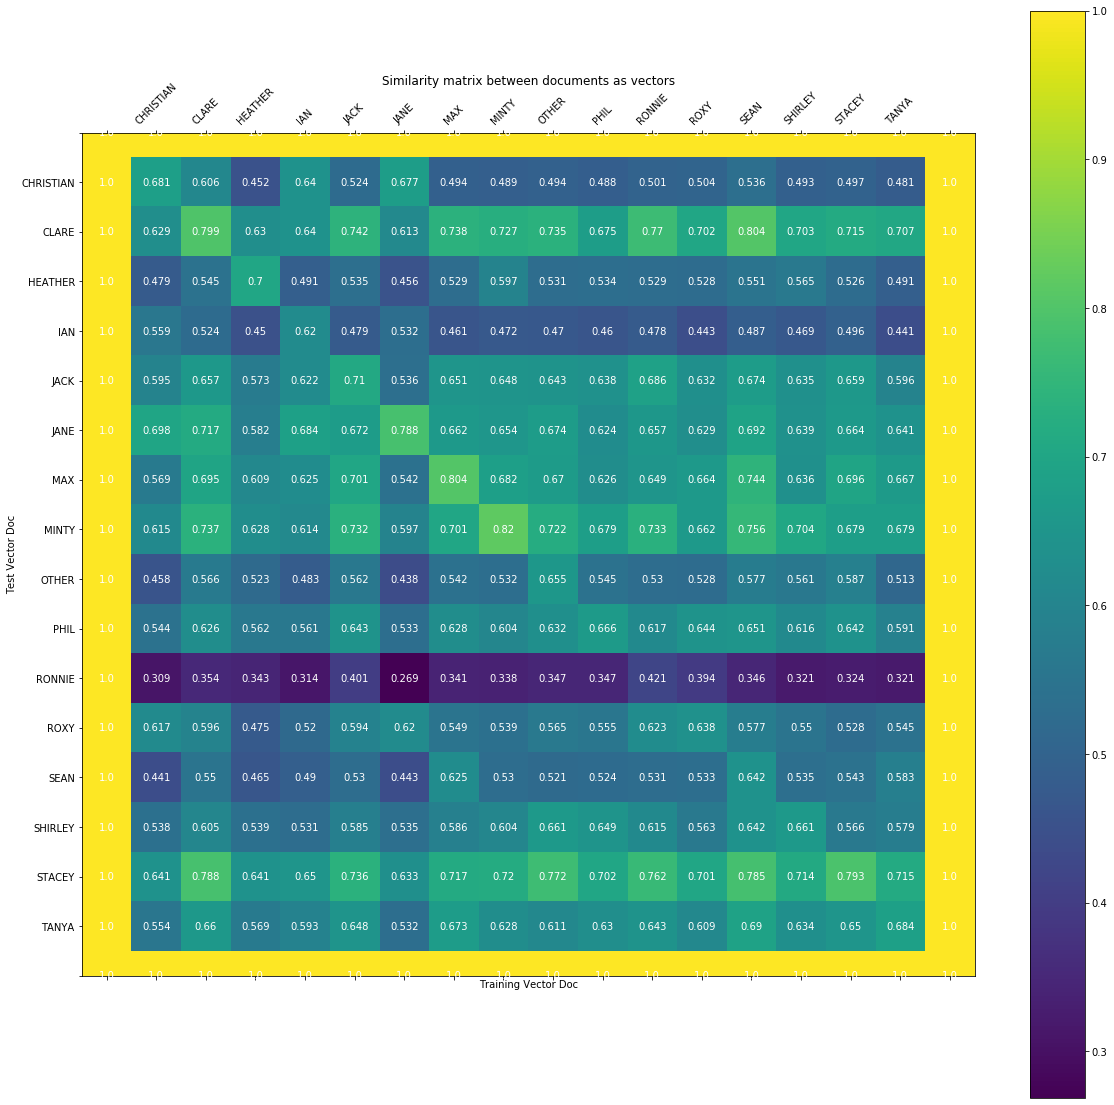

In [61]:
plot_heat_map_similarity(df)

# Notes for Q3 results for report
* The overall performance is not improved by adding the previous line but not vastly different (MR=1.5).
* However, on closer inspection, some of the lines from previous characters are useful, e.g. prev-Ian is the third highest ranked feature and prev-Phil is also highly ranked.
* This means the previous character is either addressing or referring to those character names, which in turn helps to distinguish them
* Ronnie ends up being very dissimilar to the other characters in this setting and with these features (see plot above).
* No improvement was found adding the scene information to the prev line, and in the implementation of adding all the separate words in the scene information, this made the result considerably worse across the board (best MR=2.0, min doc freq 2, max n 2, num features 400) however showed a very different pattern for the best k features for the best setting, where the scene information feature words dominate the most discriminative features, so they certainly do help, but not with this particular set up.

# Q4. Improve the vectorization method (10 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

In [62]:
# Solution Q4
# Modify the create_document_matrix_from corpus function
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
                
# adjusting method from above to include selectkbest
def create_document_matrix_from_corpus(corpus, corpusVectorizer, k_best, tfidf_transformer, num_features, max_n, vocab, fitting=False, verbose=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """

    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, vocab=vocab, max_n=max_n) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, vocab=vocab, max_n=max_n) for name, doc in corpus])

    if fitting:
        if num_features > len(corpusVectorizer.vocabulary_):
            k_best = SelectKBest(score_func=chi2,k='all')  # change the k-best object
        k_best.fit(doc_feature_matrix, [name for name, doc in corpus])
        if verbose:
            print("best_features:")
            print_k_best_features(corpusVectorizer, k_best)
    doc_feature_matrix = k_best.transform(doc_feature_matrix)
    
    if fitting:
        tfidf_transformer.fit(doc_feature_matrix.toarray())
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix.toarray())
    print(doc_feature_matrix.shape)
    return doc_feature_matrix, corpusVectorizer, k_best, tfidf_transformer

In [63]:
# run the above again with the tf-idf transformation
def test_hyper_params(min_doc_freq, max_n, num_features, verbose=False):
    """A function to test the hyper-params of the model.
    min_doc_freq : the minimum number of documents in which a feature should appear for it to be included
    max_n : the longest n-gram features to include
    num_features : the max number of features to include (i.e. the k for k-best ranking)
    """
    print("min_doc_freq", min_doc_freq)
    print("max_n", max_n)
    print("num_features", num_features)
    training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]

    # create vocab acc. min df
    vocab = create_vocab(min_doc_freq, training_corpus)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    
    # create the corpus Vectorizer
    corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts

    # create the k-best feature selector
    k_best = SelectKBest(score_func=chi2,k=num_features) #select the best features using chi^2
    
    # create tf-idf transformer
    tfidf_transformer = TfidfTransformer()


    print("extracting training features")
    # Transform and fit on the training data
    training_feature_matrix, corpusVectorizer, k_best, tfidf_transformer = create_document_matrix_from_corpus(training_corpus,
                                                                                       corpusVectorizer,
                                                                                       k_best,
                                                                                       tfidf_transformer,
                                                                                       num_features,
                                                                                       max_n,
                                                                                       vocab,
                                                                                       fitting=True,
                                                                                       verbose=verbose)
    print("extracting validation features")
    # Just transform the val_feature_matrix, don't fit
    val_feature_matrix, corpusVectorizer, k_best, tfidf_transformer = create_document_matrix_from_corpus(val_corpus,
                                                                                  corpusVectorizer,
                                                                                  k_best,
                                                                                  tfidf_transformer,
                                                                                  num_features,
                                                                                  max_n,
                                                                                  vocab,
                                                                                  fitting=False,
                                                                                  verbose=False)

    mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix,
                                                                              val_feature_matrix,
                                                                              train_labels,
                                                                              val_labels)
    return mean_rank, mean_cosine_similarity, acc, df


In [64]:
# will try Q2's feature selection again with TF-IDF transformation
if False:
    best_mean_rank = 9  # initial best mean rank to beat
    best_min_doc_freq = None
    best_max_n = None
    best_num_features = None

    for min_doc_freq in min_doc_freq_exp:
        for max_n in max_n_exp:
            for num_features in num_features_exp:
                print("*" * 30)
                mean_rank, mean_cosine_similarity, acc, df = test_hyper_params(min_doc_freq, max_n, num_features)

                #plot_heat_map_similarity(df)
                if mean_rank < best_mean_rank:
                    best_mean_rank = mean_rank
                    best_min_doc_freq = min_doc_freq
                    best_max_n = max_n
                    best_num_features = num_features

    # set the default values to the best values
    min_doc_freq = best_min_doc_freq 
    max_n = best_max_n
    num_features = best_num_features
    print("*" * 50)
    print("best mean rank", best_mean_rank)
    print("best min doc freq", min_doc_freq)
    print("best max n", max_n)
    print("best num features", num_features)

In [65]:
if True:   # results of the best settings above
    best_min_doc_freq  = 1
    best_max_n = 2
    best_num_features = 2000

In [68]:
# set the default values to the best values
min_doc_freq = best_min_doc_freq 
max_n = best_max_n
num_features = best_num_features
print("*" * 50)
print("best min doc freq", min_doc_freq)
print("best max n", max_n)
print("best num features", num_features)

**************************************************
best min doc freq 1
best max n 2
best num features 2000


In [69]:
mean_rank, mean_cosine_similarity, acc, df = test_hyper_params(min_doc_freq, max_n, num_features, verbose=True)
print(mean_rank, mean_cosine_similarity, acc)

min_doc_freq 1
max_n 2
num_features 2000
vocab size= 9148
extracting training features
best_features:
Ian 441.7073170731707
Minty 329.33333333333337
prev-Ian 304.5652173913043
Tan 281.258064516129
Gal 254.68421052631578
Shirl 236.0
Hev 224.88235294117646
Christian 213.52941176470588
Rainey 210.0
Hazel 201.04761904761904
Jack 196.0
Ian_EOL 189.38709677419354
Mum 188.38775510204084
prev-Phil 186.66666666666669
Jack_EOL 165.6
Ron 162.0
Jane 154.71428571428572
prev-Minty 154.63636363636363
Minty_EOL 150.66666666666669
Babe 150.0
Dean 150.0
EOL_Ian 149.63636363636363
Max 145.22222222222223
prev-EOL_prev-Ian 141.28571428571428
Tanya 140.24444444444444
Phil 139.51724137931035
prev-Rainey 135.9090909090909
prev-Mum 133.7179487179487
prev-Jack 132.42222222222222
prev-Ian_prev-EOL 131.53846153846155
Bradley 130.7674418604651
prev-Gal 127.71428571428572
prev-Christian 127.13793103448276
Tan_EOL 126.66666666666666
prev-Hazel 125.45714285714284
prev-Tan 124.90909090909092
Shirl_EOL 124.0
Carly 121.

prev-fate 30.0
prev-feel_prev-funny 30.0
prev-feeling_prev-like 30.0
prev-film 30.0
prev-fisherman 30.0
prev-fool 30.0
prev-fool_prev-EOL 30.0
prev-forty_prev-six 30.0
prev-fully_prev-booked 30.0
prev-get_prev-bit 30.0
prev-get_prev-choice 30.0
prev-go_prev-police 30.0
prev-go_prev-wholesaler 30.0
prev-gonna_prev-ring 30.0
prev-got_prev-eat 30.0
prev-grumpy 30.0
prev-guitar 30.0
prev-guitar_prev-I 30.0
prev-ha 30.0
prev-happened_prev-Kevin 30.0
prev-hard_prev-feeling 30.0
prev-he_prev-different 30.0
prev-he_prev-gone 30.0
prev-he_prev-lovely 30.0
prev-hen 30.0
prev-here 30.0
prev-home_prev-No 30.0
prev-homosexual 30.0
prev-husband_prev-EOL 30.0
prev-industrial 30.0
prev-industrial_prev-estate 30.0
prev-isnt_prev-I 30.0
prev-kill_prev-someone 30.0
prev-know_prev-But 30.0
prev-know_prev-minute 30.0
prev-laughing 30.0
prev-legit 30.0
prev-legit_prev-No 30.0
prev-light_prev-food 30.0
prev-like_prev-home 30.0
prev-like_prev-like 30.0
prev-living_prev-sister 30.0
prev-lock_prev-EOL 30.0
prev

(16, 2000)
mean rank 1.0625
mean cosine similarity 0.6553445054177449
15 correct out of 16 / accuracy: 0.9375
1.0625 0.6553445054177449 0.9375


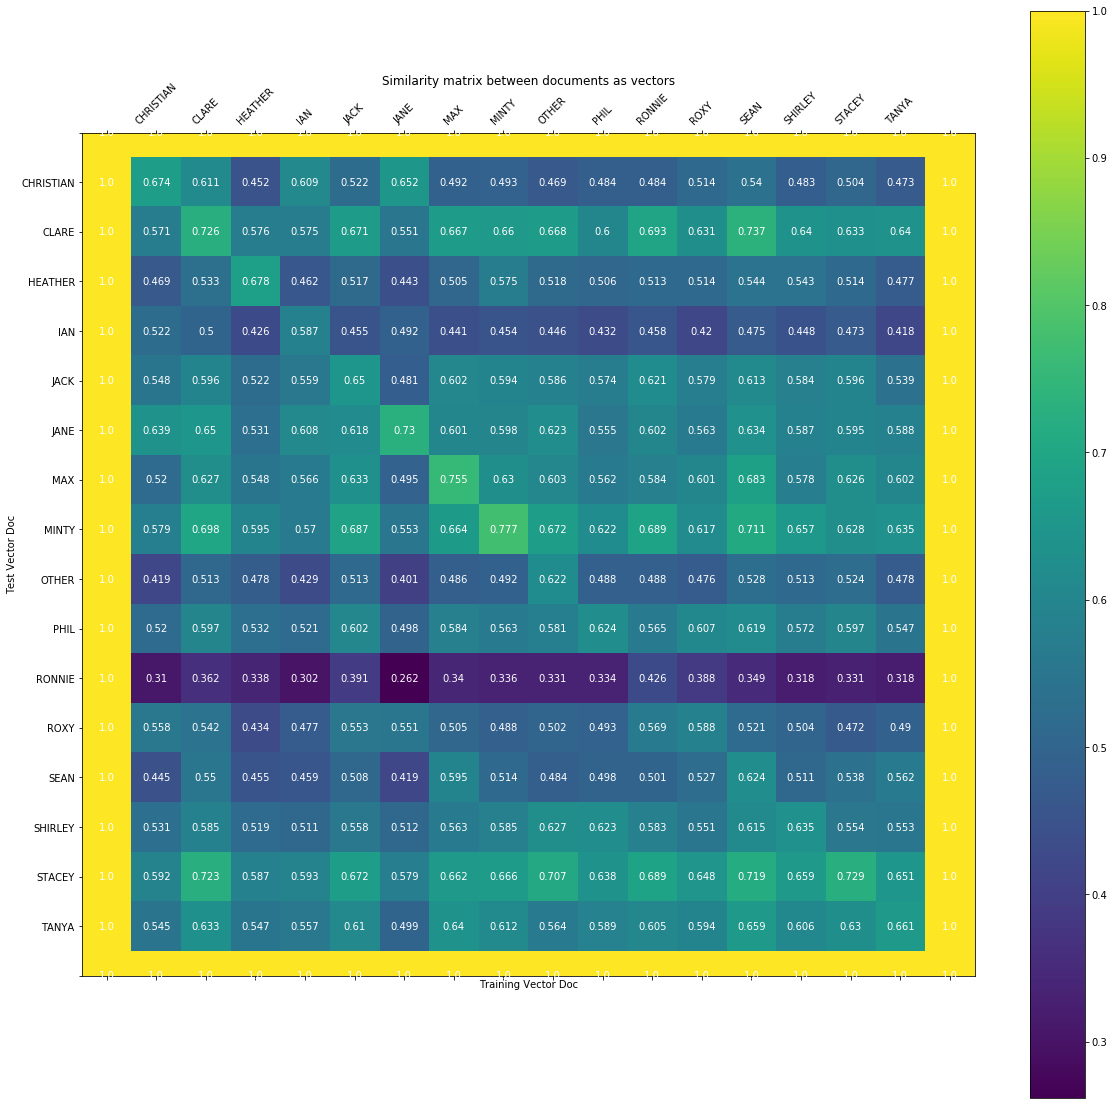

In [70]:
plot_heat_map_similarity(df)

# Notes for Q4 results for report
* Key to achieving this part was to run the tf-idf transformation on data after the corpus vectorizer (and k-best selection) had transformed it.
* Leaving in the previous line features, using tf-idf allowed for improvements across the board.
* The best hyper-params when using tf-idf show a marked improvement over the best result using plain vectorization above (MR=1.0625, 15/16 correct) - note the stronger lightness in the diagnoal in the heatmap above.
* The best hyper-params used bigram features and 'prev-EOL_prev-Ian' (i.e. that the previous line began with 'Ian') was one of the strongest overall features.

# Q5. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [72]:
# needed to make the columns the same as the training file
epsiode_scene_column = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = epsiode_scene_column

In [75]:
print("min doc freq", min_doc_freq)
print("max n", max_n)
print("num features", num_features)

# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

# adding this in:
vocab = create_vocab(min_doc_freq, training_corpus)

# create the k-best feature selector
k_best = SelectKBest(score_func=chi2,k=num_features) #select the best features using chi^2


# create tf-idf transformer
tfidf_transformer = TfidfTransformer()

# Transform and fit on the training data
print("extracting training features")
# Transform and fit on the training data
training_feature_matrix, corpusVectorizer, k_best, tfidf_transformer = create_document_matrix_from_corpus(training_corpus,
                                                                                   corpusVectorizer,
                                                                                   k_best,
                                                                                   tfidf_transformer,
                                                                                   num_features,
                                                                                   max_n,
                                                                                   vocab,
                                                                                   fitting=True,
                                                                                   verbose=True)


# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


print("extracting test features")
# Just transform the test_feature_matrix, don't fit
test_feature_matrix, corpusVectorizer, k_best, tfidf_transformer = create_document_matrix_from_corpus(test_corpus,
                                                                                  corpusVectorizer,
                                                                                  k_best,
                                                                                  tfidf_transformer,
                                                                                  num_features,
                                                                                  max_n,
                                                                                  vocab,
                                                                                  fitting=False,
                                                                                  verbose=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

min doc freq 1
max n 2
num features 2000
lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  8610
OTHER Number of Words:  7423
JACK Number of Words:  8811
RONNIE Number of Words:  8894
TANYA Number of Words:  8912
SEAN Number of Words:  8554
ROXY Number of Words:  8323
HEATHER Number of Words:  8960
MAX Number of Words:  9792
IAN Number of Words:  9501
JANE Number of Words:  8654
STACEY Number of Words:  8441
PHIL Number of Words:  8878
MINTY Number of Words:  8752
CHRISTIAN Number of Words:  8367
CLARE Number of Words:  9494
total words 140366
vocab size= 9807
extracting training features
best_features:
Ian 469.18367346938777
Minty 343.1081081081081
Tan 336.65714285714284
prev-Ian 322.0120481927711
Shirl 318.9411764705883
Gal 314.3913043478261
Ch

prev-much_prev-dont 30.0
prev-natural 30.0
prev-natural_prev-EOL 30.0
prev-neck 30.0
prev-need_prev-sorting 30.0
prev-new_prev-opening 30.0
prev-night_prev-Jacks 30.0
prev-noone 30.0
prev-normal_prev-EOL 30.0
prev-nothing_prev-worth 30.0
prev-number_prev-one 30.0
prev-one_prev-say 30.0
prev-one_prev-supposed 30.0
prev-opening_prev-hour 30.0
prev-orange 30.0
prev-oversleep 30.0
prev-performance_prev-EOL 30.0
prev-pink_prev-jumper 30.0
prev-place_prev-legit 30.0
prev-please_prev-Jane 30.0
prev-plumber 30.0
prev-pram 30.0
prev-prawn 30.0
prev-previous 30.0
prev-punish 30.0
prev-punished 30.0
prev-really_prev-go 30.0
prev-relationship 30.0
prev-rely 30.0
prev-room_prev-Ronnie 30.0
prev-round_prev-Dots 30.0
prev-row 30.0
prev-sat_prev-outside 30.0
prev-say_prev-‚no 30.0
prev-saying_prev-pink 30.0
prev-scared_prev-Im 30.0
prev-see_prev-dress 30.0
prev-seen_prev-like 30.0
prev-settle 30.0
prev-shower 30.0
prev-shuts_prev-want 30.0
prev-side_prev-EOL 30.0
prev-six_prev-forty 30.0
prev-skate 30

extracting test features
(16, 2000)
mean rank 1.75
mean cosine similarity 0.6746965342146553
13 correct out of 16 / accuracy: 0.8125


/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


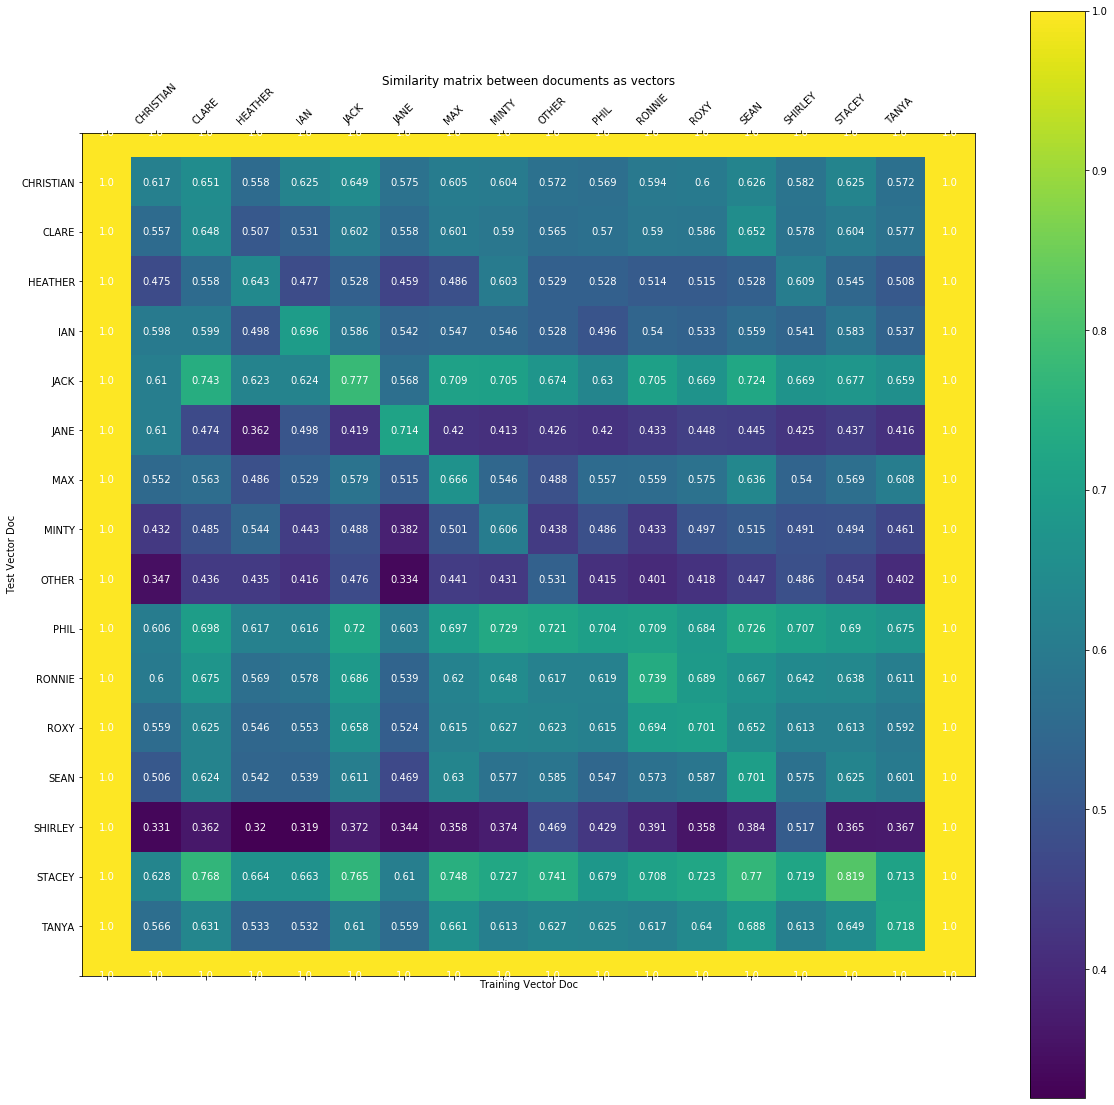

In [76]:
plot_heat_map_similarity(df)

# Notes for Q5 for report
* The best settings' results yield an MR of 1.75, below the optimized 1.0625 on the validation set, however still quite strong, with a far better, lighter diagonal line in the above heatmap compared to the template code at the beginnning, and considerably better than the baseline on the heldout and test data (MR=4.5 and MR=5.12).
* Several code modifications were made to accomodate the k_best, tf-idf and associated different parameters.
* The optimization was done over the best feature selection from Q3's additional contextual features (rather than just Q2's lexical) as per the code in Q4, to give the best hyper-params min doc freq = 1, max n 2 and num features 2000.
